PROJETO ANALISE DE DADOS IMPACTA 

Estudo de Caso - Reconhecimento Facial com Machine Learning Usando SVM e PCA

O objetivo deste estudo de caso é mostrar a você uma aplicação prática de Machine Learning com o algoritmo SVM (Support Vector Machines) e PCA (Principal Component Analysis) para redução de dimensionalidade.

Definição do Problema
Vamos criar um modelo para reconhecimento facial, usando SVM e PCA.

Essa abordagem trata o reconhecimento de face como um problema de reconhecimento bidimensional, aproveitando o fato de que as faces normalmente estão na posição vertical e, portanto, podem ser descritas por um pequeno conjunto de características 2D. As imagens de rosto são projetadas em um espaço de recurso ('espaço de rosto') que melhor codifica a variação entre imagens de rosto conhecidas.

O PCA é aplicado para reduzir a dimensionalidade dos dados e então treinar o modelo SVM para uma tarefa de classificação.

Leia atentamente cada comentário que incluímos nas células, explicando todo o processo passo a passo.

![alt text](https://i.gifer.com/Kdef.gif)

In [3]:
# Carregando pacotes
# Armazenamento de imagens
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import svm

# Dataset de imagens
from sklearn import datasets

# Criação de gráficos
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Carregando o Dataset
Vamos usar neste Estudo de Caso, um dataset famoso para tarefas de reconhecimento facial. E disponível publicamente.

O Dataset Labeled Faces in the Wild Home é um conjunto de imagens de faces preparadas para tarefas de Visão Computacional. O dataset pode ser baixado em http://vis-www.cs.umass.edu/lfw/, mas ele ja está disponível no Keras, o framework de Deep Learning mais usado na atualidade.

Observe que este é um download relativamente grande (~ 200 MB), portanto, pode demorar um pouco dependendo da sua conexão à internet.

In [4]:
# Carrega o dataset (é feito o download na primeira execução)
# Faremos o download de no mínimo 70 imagens por pessoa com fator de redimensionamento de 0.4
dataset_faces = datasets.fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)

In [5]:
# Vamos conferir o shape do dataset
dataset_faces.data.shape

(1217, 1850)

In [6]:
# Conferindo as imagens
dataset_faces.data

array([[ 57.      ,  60.333332,  73.333336, ...,  20.333334,  22.      ,
         20.333334],
       [ 11.      ,  13.333333,  15.666667, ..., 120.666664, 122.666664,
        132.      ],
       [194.66667 , 177.66667 , 162.66667 , ..., 189.66667 , 204.33333 ,
        215.66667 ],
       ...,
       [ 68.      ,  78.      ,  94.      , ..., 243.      , 201.      ,
         65.      ],
       [ 50.333332,  65.666664,  88.      , ..., 197.      , 179.33333 ,
        166.33333 ],
       [ 79.      ,  83.666664, 103.      , ...,  47.666668,  47.      ,
         50.      ]], dtype=float32)

Viu as imagens acima? Como não? Imagens são apenas representações numéricas, são matrizes de pixels, onde cada pixel representa uma tonalidade de cor. Vários pixels juntos formam as belas imagens que vemos no computador todos os dias.

Mas fique tranquilo, que daqui a pouco eu mostro as imagens em um formato mais "amigável".

Preparando o Dataset
Vamos preparar o dataset para visualizarmos algumas imagens e na sequência construiremos o modelo de reconhecimento facial.

In [7]:
# Vamos extrair os detalhes do shape (formato) das imagens
num_amostras, altura, largura = dataset_faces.images.shape

In [8]:
# Este é o número de imagens no dataset
num_amostras

1217

In [9]:
# Esta é a altura de cada imagem (número de pixels)
altura

50

In [10]:
# Esta é a largura de cada imagem (número de pixels)
largura

37

Ou seja, temos 1288 imagens, cada uma com dimensões 50 x 37 pixels.

In [11]:
# Quando carregamos os dados com o Keras, ele oferece dois atributos para o dataset: data e target
# Colocamos data em X (variáveis de entrada) e target em y (variável de saída)
X = dataset_faces.data

In [12]:
# Número de atributos de x
num_atributos = X.shape[1]
num_atributos

1850

O que representa o valor 1850? O número de pixels com o qual iremos trabalhar para treinar o modelo. Imagine isso como se fossem 1850 variáveis em seu dataset (na verdade é exatamente isso). A diferença é que cada variável representa um pixel. Vamos imprimir X:

In [13]:
print(X)

[[ 57.        60.333332  73.333336 ...  20.333334  22.        20.333334]
 [ 11.        13.333333  15.666667 ... 120.666664 122.666664 132.      ]
 [194.66667  177.66667  162.66667  ... 189.66667  204.33333  215.66667 ]
 ...
 [ 68.        78.        94.       ... 243.       201.        65.      ]
 [ 50.333332  65.666664  88.       ... 197.       179.33333  166.33333 ]
 [ 79.        83.666664 103.       ...  47.666668  47.        50.      ]]


Cada pixel pode ter um valor de 0 a 255, para imagens em preto e branco.

In [14]:
# Colocamos o target em y
y = dataset_faces.target

In [15]:
# Vamos extrair os nomes das classes
target_names = dataset_faces.target_names

In [16]:
# Vejamos quantas classes nós temos
num_classes = target_names.shape[0]
num_classes

6

O que representa o número 7? O número de pessoas que nosso modelo pode classificar, ou seja, temos fotos de 7 pessoas diferentes.

Mas então isso aqui é um problema de classificação em Machine Learning? Sim, isso mesmo. Vamos imprimir y.

In [17]:
print(y)

[3 1 0 ... 5 3 5]


In [18]:
# Vamos imprimir um resumo dos dados
print("\nTamanho Total do Dataset:\n")
print("Número de Amostras: %d" % num_amostras)
print("Número de Atributos: %d" % num_atributos)
print("Número de Classes: %d" % num_classes)


Tamanho Total do Dataset:

Número de Amostras: 1217
Número de Atributos: 1850
Número de Classes: 6


Visualizando os Dados
Tenho certeza que você deve estar ansioso para visualizar as imagens. Então, vamos imprimir uma amostra

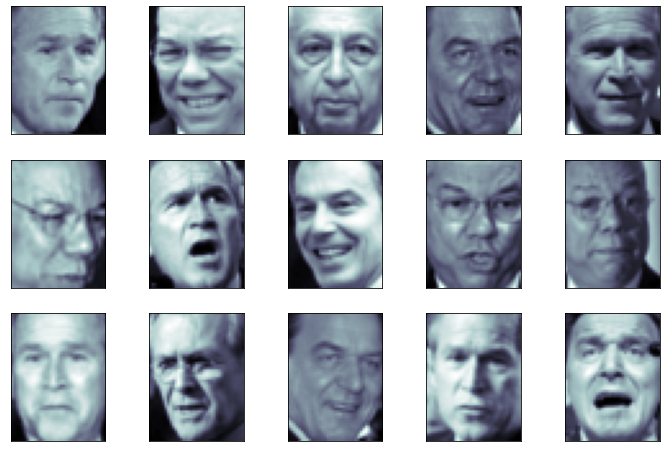

In [19]:
# Plot de imagens

# Define o tamanho da área de plotagem
fig = plt.figure(figsize = (12, 8))

# Plot de 15 imagens
for i in range(15):
    
    # Dividimos a área total de plotagem definido acima, em subplots, 
    # um para cada bloco de imagens, com 5 colunas e 3 linhas
    ax = fig.add_subplot(3, 5, i + 1, xticks = [], yticks = [])
    
    # Mostramos as imagens
    ax.imshow(dataset_faces.images[i], cmap = plt.cm.bone)

Agora sim! Mas não é assim que o computador vê as imagens. Para o algoritmo passamos uma matriz de pixels.

Visualizando a Distribuição do Dataset

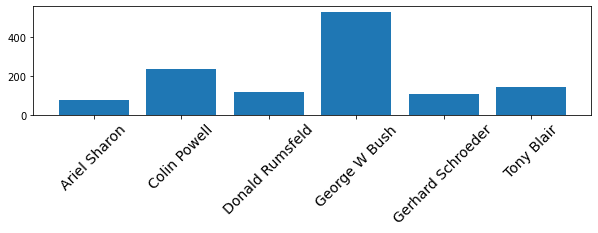

In [20]:
# Define o tamanho da área de plotagem
plt.figure(figsize = (10, 2))

# Capturamos valores únicos do target (classe)
unique_targets = np.unique(dataset_faces.target)

# Contamos o total de cada classe
counts = [(dataset_faces.target == i).sum() for i in unique_targets]

# Plot do resultado
plt.xticks(unique_targets, dataset_faces.target_names[unique_targets])
locs, labels = plt.xticks()
plt.setp(labels, rotation = 45, size = 14)
_ = plt.bar(unique_targets, counts)

Uma coisa a observar é que essas faces já foram localizadas e redimensionadas para um tamanho comum. Esta é uma peça importante de pré-processamento para reconhecimento facial e é um processo que pode exigir uma grande coleta de dados de treinamento. Isso pode ser feito com Scikit-Learn, mas o desafio é reunir uma quantidade suficiente de dados de treinamento para o algoritmo funcionar.

Precisamos dividir os dados em treino e teste, como em qualquer modelo de Machine Learning.

In [21]:
# Dividimos os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(dataset_faces.data, dataset_faces.target, random_state = 0)

In [22]:
# Print
print(X_treino.shape, X_teste.shape)

(912, 1850) (305, 1850)


Para treino temos 966 imagens e 1850 atributos, ou pixels das imagens.
Para teste temos 322 imagens e 1850 atributos, ou pixels das imagens.

Pré-Processamento: Principal Component Analysis (PCA)
    
    
Os 1850 atributos representam 1850 dimensões, o que é muito para modelos SVM. Podemos usar o PCA para reduzir esses recursos de 1850 a um nível gerenciável mantendo a maioria das informações no conjunto de dados. Aqui é útil usar uma variante do PCA chamado RandomizedPCA, que é uma aproximação do PCA que pode ser muito mais rápida para grandes conjuntos de dados.    

In [23]:
# Criamos o modelo PCA com 150 componentes.
# Cada componente terá a mesma informação que um grupo de variáveis e assim reduzimos de 1850 para 150 dimensões.
# Aqui você encontra detalhes sobre os demais parâmetros do PCA:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = decomposition.PCA(n_components = 150, 
                        whiten = True,
                        random_state = 1999, 
                        svd_solver = 'randomized')

In [24]:
# Treinamos o modelo PCA somente com os dados de treino
# O PCA é um algoritmo de aprendizagem não supervisionada
pca.fit(X_treino)

PCA(n_components=150, random_state=1999, svd_solver='randomized', whiten=True)

In [25]:
# E então aplicamos o modelo PCA nos dados de treino e de teste
X_treino_pca = pca.transform(X_treino)
X_teste_pca = pca.transform(X_teste)

In [26]:
# Shape
print(X_treino_pca.shape)
print(X_teste_pca.shape)

(912, 150)
(305, 150)


Esses 150 componentes correspondem a fatores em uma combinação linear de imagens de modo que a combinação se aproxime da face original. Em geral, o PCA pode ser uma técnica poderosa de pré-processamento que pode melhorar significativamente o desempenho da classificação.

Construção do Modelo de Machine Learning com SVM
Agora criamos e treinamos um classificador com o SVM.

In [27]:
# Cria o modelo
modelo_svm = svm.SVC(C = 5., gamma = 0.001)

In [28]:
# Treinamento do modelo
modelo_svm.fit(X_treino_pca, y_treino)

SVC(C=5.0, gamma=0.001)

Avaliação do Modelo
Por fim, podemos avaliar o desempenho desse modelo de classificação usando as imagens de teste.

In [29]:
# Shape dos dados de teste
print(X_teste.shape)

(305, 1850)


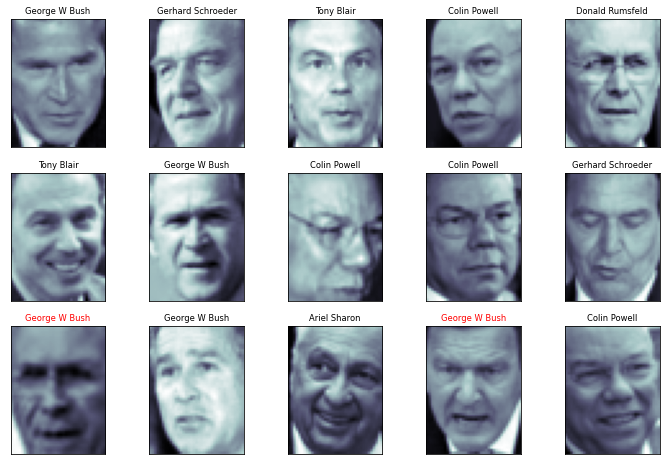

In [30]:
# Tamanho da área de plotagem
fig = plt.figure(figsize = (12, 8))

# Loop por 15 imagens
for i in range(15):
    
    # Subplots
    ax = fig.add_subplot(3, 5, i + 1, xticks = [], yticks = [])
    
    # Mostra a imagem real no dataset de teste
    ax.imshow(X_teste[i].reshape((50, 37)), cmap = plt.cm.bone)
    
    # Faz a previsão de classe com o modelo treinado
    y_pred = modelo_svm.predict(X_teste_pca[i].reshape(1,-1))[0]
    
    # Se a previsão de classe for igual a classe real, colocamos o nome em preto, se não em vermelho
    # Nome em vermelho significa erro do modelo
    color = 'black' if y_pred == y_teste[i] else 'red'
    
    # Define o título
    ax.set_title(dataset_faces.target_names[y_pred], fontsize = 'small', color = color)

Observando as imagens, nomes em vermelho representam erro do modelo.

Vamos quantificar o erro calculando o score do modelo.

In [32]:
print(modelo_svm.score(X_teste_pca, y_teste))

0.8786885245901639


Nosso modelo tem uma eficência de aproximadamente 87%, ou seja, a cada 100 imagens, acerta a previsão em 87 casos.

Conseguimos melhorar essa performance? Provavelmente sim. Podemos tentar mudar o número de componentes principais, ajustar os hiperparâmetros do modelo PCA e SVM ou até mesmo usar um dataset maior.

Mas isso, agora é com você.

##### FIM  ######